In [66]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import random
from sklearn.model_selection import train_test_split
import tensorflow.keras.datasets.cifar10
import keras
from keras_preprocessing.image import ImageDataGenerator
from functools import partial
from confusion_matrix import make_confusion_matrix
from sklearn.metrics import confusion_matrix



In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Bronnen:

- hands on machine learning with scikit-learn keras and tensorflow: Chapter 14 - Deep Computer Vision Using Convolutional Neural Networks
- MIT 6.S191 (2020): Convolutional Neural Networks (https://www.youtube.com/watch?v=iaSUYvmCekI)
- https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/


# Data Preparation

In [3]:
# zonder dit krijg ik een error bij het downloaden van de dataset
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
data = keras.datasets.cifar10.load_data()

In [5]:
label_dict = {0:'airplane', 1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

In [6]:
(X_train, y_train), (X_test, y_test) = data

In [7]:
# one-hot encode the targets
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [8]:
X_train.shape

(50000, 32, 32, 3)

# Data Augmentation
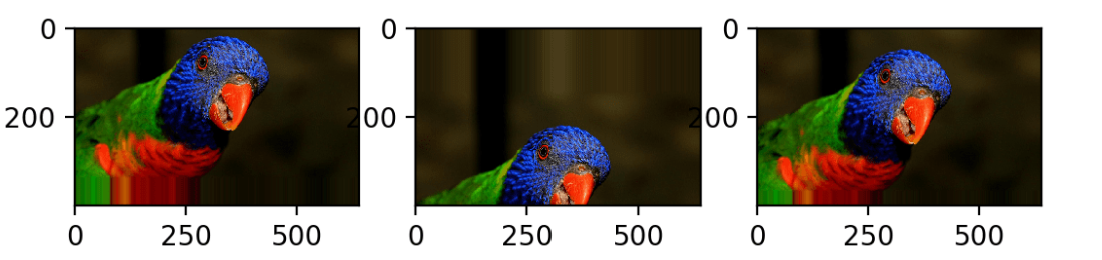
Positief effect op accuracy:

    - horizontal flip
    - brightness

Negatief of geen effect op accuracy:

    - height/width shift
    - rotation
    - zoom


In [9]:
datagen = ImageDataGenerator(horizontal_flip=True, brightness_range=[0.5,1.5])
it_train = datagen.flow(X_train, y_train, batch_size=64)
steps = len(X_train)/64

# Soorten Layers

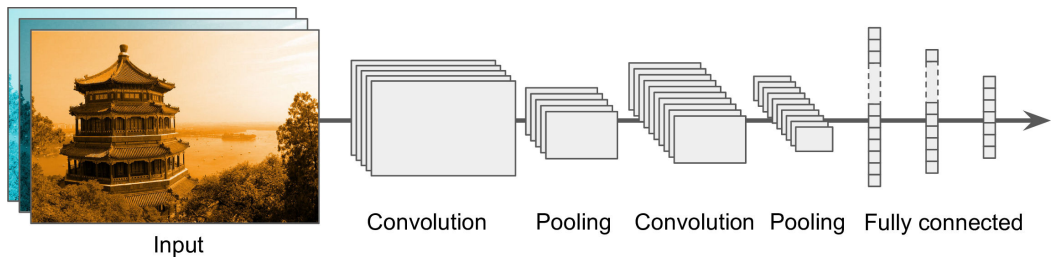

### - Rescaling Layers:
In deze layer normaliseren we de input data, we doen dit door alle waardes te delen door de grootste waarde: 255. Dit zorgt er voor dat ons network sneller kan convergeren.


### - Convolutional Layers:
Convolutional layers worden gebruikt als 'feature extractors'. In een convolutional layer slide een filter (een matrix van x bij y getallen die een patroon representeerd) over onze image bitmap met als doel een map te maken van waar het filterpatroon overeenkomt met een deel van onze image. Dit wordt gedaan door de getallen in het filter te vermenigvuldigen met de getallen van het deel van de de bitmap waar het filter op wordt toegepast en daar de som van te nemen, eventueel een bias er aan toe te voegen, en het in een activatie functie te stoppen.We gebruiken hier de non-lineaire activatiefunctie ReLu voor omdat onze data ook non-lineair is. Dit resultaat is dan één getal in de nieuwe feature map. Hoe vaak dit wordt gedaan is afhankelijk van de grootte van het filter, de grootte van de bitmap, en de strides variabele (de horizontale en verticale stapgrootte). De filters variabele geeft aan hoeveel van deze feature maps, met verschillende filters, worden gemaakt.

Je kan zien dat na elke convolutional + pooling cycle het aantal filters verdubbeld wordt. Dit wordt zo gedaan omdat des te dieper je het netwerk in gaat des te complexer de patronen, en vooral de combinaties van patronen worden. Een van de eerdere convolutional layers kijkt dus bijvoorbeeld naar relatief simpele patronen zoals randen, maar de latere convolutional layers kunnen deze randen samenvoegen om meer complexere vormen te herkennen zoals een vleugel van een vliegtuig. Dit vergt natuurlijk redelijk veel computationele kracht en is dan ook een van de redenen om de volgende soort layers te gebruiken:

### - Pooling Layers:
Waar in onze convolutional layer het filter willekeurig geïnitialiseerd werd werkt het bij pooling layers net even iets anders. Bij max pooling (de methode die ik gebruik) wordt er ook een filter toegepast op de bitmap maar dit filter neemt alleen het grootste getal op het toegepaste deel over naar de feature map. Het maakt in principe dus een soort samenvatting van de bitmap. Dit is een vorm van downsampling. Pooling layers leiden tot een enorme performance gain voor ons netwerk. Dit verminderen van je features kan ook helpen tegen overfitting.

### - Dense Layers:
### - Dropout Layers:

In [10]:
# deze parameters worden voor alle convolutional layers gebruikt
DefaultConv2D = partial(keras.layers.Conv2D,
 kernel_size=3, activation='relu', padding="same")


model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(32, 32, 3)),
    
    DefaultConv2D(filters = 32),
    tf.keras.layers.BatchNormalization(),
    DefaultConv2D(filters = 32),
    tf.keras.layers.BatchNormalization(),
    DefaultConv2D(filters = 32),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    DefaultConv2D(filters = 64),
    tf.keras.layers.BatchNormalization(),
    DefaultConv2D(filters = 64),
    tf.keras.layers.BatchNormalization(),
    DefaultConv2D(filters = 64),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    DefaultConv2D(filters = 128),
    tf.keras.layers.BatchNormalization(),
    DefaultConv2D(filters = 128),
    tf.keras.layers.BatchNormalization(),
    DefaultConv2D(filters = 128),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation = 'relu', kernel_initializer = 'he_uniform'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10,activation = 'softmax')
])

model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
              metrics = ['accuracy']
              
             )


early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                              patience=5)

history = model.fit(it_train,steps_per_epoch = steps ,epochs = 100,validation_data = (X_test,y_test), callbacks = [early_stop], batch_size = 64)

Epoch 1/100
781/781 [==============================] - 27s 32ms/step - loss: 2.0365 - accuracy: 0.3150 - val_loss: 1.4564 - val_accuracy: 0.4674
Epoch 2/100
781/781 [==============================] - 25s 32ms/step - loss: 1.5222 - accuracy: 0.4518 - val_loss: 1.7259 - val_accuracy: 0.4407
Epoch 3/100
781/781 [==============================] - 25s 32ms/step - loss: 1.3024 - accuracy: 0.5335 - val_loss: 1.1271 - val_accuracy: 0.5910
Epoch 4/100
781/781 [==============================] - 25s 32ms/step - loss: 1.1625 - accuracy: 0.5804 - val_loss: 0.9477 - val_accuracy: 0.6625
Epoch 5/100
781/781 [==============================] - 25s 32ms/step - loss: 1.0712 - accuracy: 0.6166 - val_loss: 0.9133 - val_accuracy: 0.6731
Epoch 6/100
781/781 [==============================] - 25s 32ms/step - loss: 0.9918 - accuracy: 0.6475 - val_loss: 0.8411 - val_accuracy: 0.6992
Epoch 7/100
781/781 [==============================] - 25s 32ms/step - loss: 0.9263 - accuracy: 0.6691 - val_loss: 0.8202 - val_ac

In [11]:
def random_classification():
    index = random.randint(0,len(X_test)-1)
    prediction = model.predict(np.expand_dims(X_test[index], axis = 0))
    label = label_dict[np.argmax(y_test[index])]
    predicted_label = label_dict[np.argmax(prediction)]
    plt.imshow(X_test[index])
    plt.title(f"Real: {label} \nPrediction: {predicted_label}\n", color = 'green' if label == predicted_label else 'red')
    plt.show()


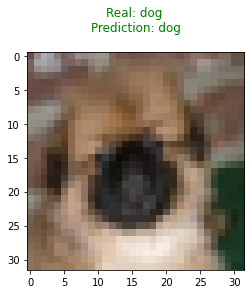

In [31]:
random_classification()

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        9

In [17]:
def plot_loss(history):
    
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
 

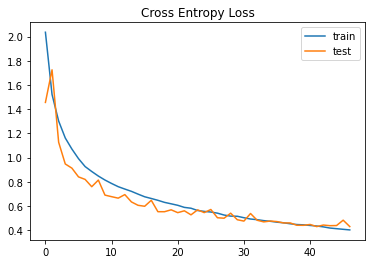

In [18]:
plot_loss(history)

In [50]:
test_preds = model.predict(X_test)
test_preds_num = [label_dict[tf.argmax(x).numpy()] for x in test_preds]

In [52]:
cm = confusion_matrix([label_dict[np.argmax(x)] for x in y_test],test_preds_num)

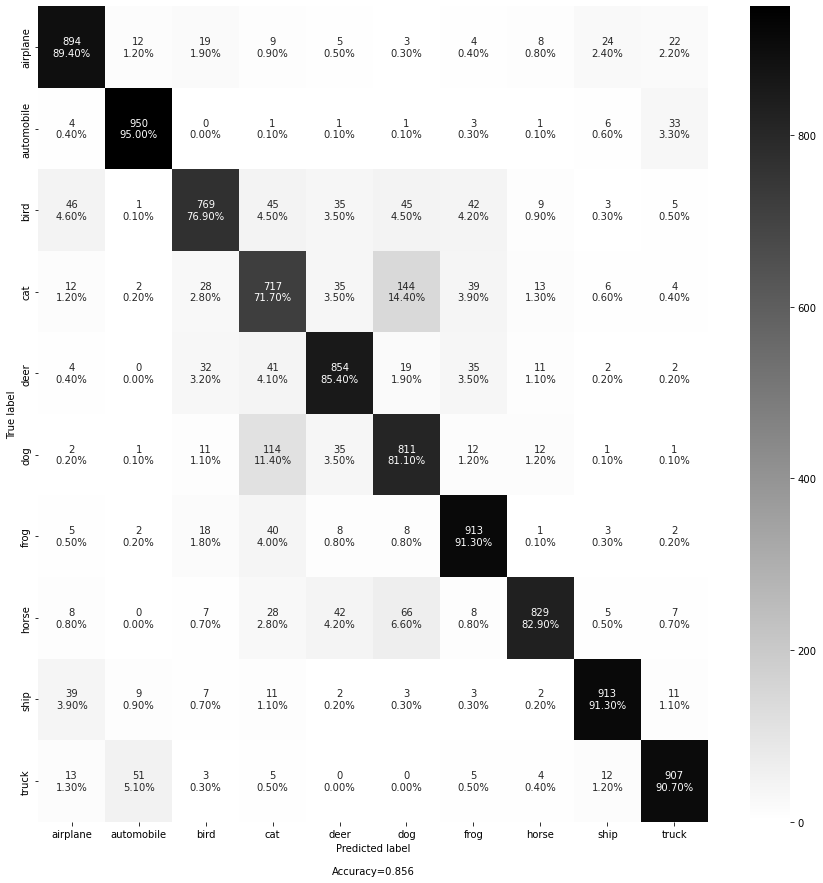

In [65]:
make_confusion_matrix(cm, 
                      cmap= 'binary',
                      figsize = (15,15),
                      categories = list(label_dict.values()))

plt.show()